In [1]:
from vampyr import vampyr3d as vp
from orbital4c import orbital as orb
import numpy as np
import importlib
importlib.reload(orb)
from scipy.special import legendre, laguerre, erf, gamma
from scipy.special import gamma
from scipy.constants import hbar


c = 137   # NOT A GOOD WAY. MUST BE FIXED!!!
alpha = 1/c
k = -1
l = 0
n = 1
m = 0.5
Z = 1

mra = vp.MultiResolutionAnalysis(box=[-20,20], order=7)
prec = 1.0e-4
origin = [0.1, 0.2, 0.3]  # origin moved to avoid placing the nuclar charge on a node

print("init test orbital")
testorb = orb.orbital4c("X",mra)

a_coeff = 3.0
b_coeff = np.sqrt(a_coeff/np.pi)**3
gauss = vp.GaussFunc(b_coeff, a_coeff, origin)
gauss_tree = vp.FunctionTree(mra)
vp.advanced.build_grid(out=gauss_tree, inp=gauss)
vp.advanced.project(prec=prec, out=gauss_tree, inp=gauss)
gauss_tree.normalize()

testorb.init_large_components(Lar = gauss_tree, Lai = gauss_tree)
testorb.init_small_components(prec/10)
testorb.rescale(2)
testorb.normalize()
testorb.gradient()
testorb.density(prec)

init test orbital

*FunctionTree: nn
  genNodes: 0
  square norm: 0.933162
  root scale: -4
  order: 7
  nodes: 264
  endNodes: 232
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=64
    scale=0  nodes=64
 
*FunctionTree: nn
  genNodes: 0
  square norm: 0.933162
  root scale: -4
  order: 7
  nodes: 264
  endNodes: 232
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=64
    scale=0  nodes=64
 
*FunctionTree: nn
  genNodes: 0
  square norm: 0.933162
  root scale: -4
  order: 7
  nodes: 264
  endNodes: 232
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=64
    scale=0  nodes=64



In [2]:
importlib.reload(orb)
spinor_H = orb.orbital4c("hydrogen",mra)
spinor_H.init_large_components(Lar = gauss_tree)
spinor_H.init_small_components(prec/10)
spinor_H.normalize()

print(gauss_tree([0.5,0.5,0.5]))
print(spinor_H["Lar"]([0.5,0.5,0.5]))


*FunctionTree: nn
  genNodes: 0
  square norm: 0.933162
  root scale: -4
  order: 7
  nodes: 264
  endNodes: 232
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=64
    scale=0  nodes=64
 
*FunctionTree: nn
  genNodes: 0
  square norm: 0.933162
  root scale: -4
  order: 7
  nodes: 264
  endNodes: 232
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=64
    scale=0  nodes=64
 
*FunctionTree: nn
  genNodes: 0
  square norm: 0.933162
  root scale: -4
  order: 7
  nodes: 264
  endNodes: 232
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=64
    scale=0  nodes=64

0.5162385294183164
0.5162289047559492


In [8]:
def u(r):
    u = erf(r)/r + (1/(3*np.sqrt(np.pi)))*(np.exp(-(r**2)) + 16*np.exp(-4*r**2))
    #erf(r) is an error function that is supposed to stop the potential well from going to inf.
    #if i remember correctly
    return u

def V(x):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    c = 0.0435
#    c = 0.000435 # ten times tighter nuclear potential
    f_bar = u(r/c)/c
    return f_bar

Peps = vp.ScalingProjector(mra,prec)
f = lambda x: V([x[0]-origin[0],x[1]-origin[1],x[2]-origin[2]])

print(f([0.5,0.5,0.5]))
V_tree = Z*Peps(f)

1.8569533817705182


In [9]:
importlib.reload(orb)
orbital_error = 1
while orbital_error > prec:
#for i in range(1):    
    hd_psi = orb.apply_dirac_hamiltonian(spinor_H, prec)
    v_psi = orb.apply_potential(V_tree, spinor_H, prec)
    add_psi = orb.add_orbitals(1.0, hd_psi, 1.0, v_psi, prec)
    energy, imag = orb.scalar_product(spinor_H, add_psi)
    print('Energy',energy,imag)
    tmp = orb.apply_helmholtz(v_psi, energy, c, prec)
    new_orbital = orb.apply_dirac_hamiltonian(tmp, prec, energy)
    new_orbital.normalize()
    delta_psi = orb.add_orbitals(1.0, new_orbital, -1.0, spinor_H, prec)
    orbital_error, imag = orb.scalar_product(delta_psi, delta_psi)
    print('Error',orbital_error, imag)
    spinor_H = new_orbital
    
hd_psi = orb.apply_dirac_hamiltonian(spinor_H, prec)
v_psi = orb.apply_potential(V_tree, spinor_H, prec)
add_psi = orb.add_orbitals(1.0, hd_psi, 1.0, v_psi, prec)
energy, imag = orb.scalar_product(spinor_H, add_psi)
print('Energy',energy)

Energy 18768.49983881293 -7.131523169233637e-11
mu 1.0001545109183014
Error 2.94085022890823e-06 0.0
Energy 18768.49993458509


In [5]:
importlib.reload(orb)
exact_orbital = orb.orbital4c("exact_1s",mra)
orb.init_1s_orbital(exact_orbital,k,Z,n,alpha,origin,prec)

Now projecting component  Lar 0 0.0072992700729927005 0.9999733599733552 0.5000156216290343
Now projecting component  Lai 1 0.0072992700729927005 0.9999733599733552 0.5000156216290343
Now projecting component  Lbr 2 0.0072992700729927005 0.9999733599733552 0.5000156216290343
Now projecting component  Lbi 3 0.0072992700729927005 0.9999733599733552 0.5000156216290343
Now projecting component  Sar 4 0.0072992700729927005 0.9999733599733552 0.5000156216290343
Now projecting component  Sai 5 0.0072992700729927005 0.9999733599733552 0.5000156216290343
Now projecting component  Sbr 6 0.0072992700729927005 0.9999733599733552 0.5000156216290343
Now projecting component  Sbi 7 0.0072992700729927005 0.9999733599733552 0.5000156216290343


In [6]:
exact_orbital.normalize()

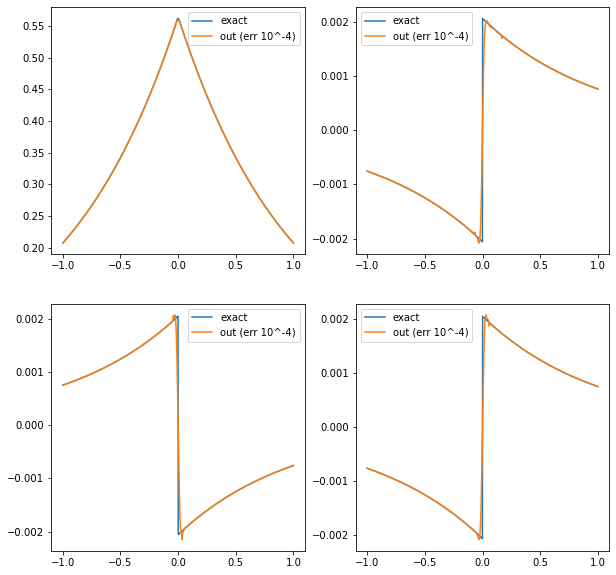

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig, axs = plt.subplots(2,2,figsize=(10, 10))
#axs[0,0].set_box_aspect(1)
#axs[0,1].set_box_aspect(1)
#axs[1,0].set_box_aspect(1)
#axs[1,1].set_box_aspect(1)
x_plt = np.linspace(-1, 1, 1000)
orbital_plt = {}
exact_plt = {}
out_plt = {}
orb_plt = {}
add_psi_plt = {}
exact_plt['Lar']   = [exact_orbital['Lar'](   [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
exact_plt['Sai']   = [exact_orbital['Sai'](   [  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
exact_plt['Sbr']   = [exact_orbital['Sbr'](   [  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
exact_plt['Sbi']   = [exact_orbital['Sbi'](   [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
orb_plt['Lar']     = [spinor_H['Lar'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
orb_plt['Sai']     = [spinor_H['Sai'](         [  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
orb_plt['Sbr']     = [spinor_H['Sbr'](         [  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
orb_plt['Sbi']     = [spinor_H['Sbi'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
#plt.plot(x_plt, [add_psi_plt['Lar'][i]/orbital_plt['Lar'][i] for i in range(1000)])
#axs[0,0].plot(x_plt, add_psi_plt['Lar'],label='add_psi')
#axs[0,0].plot(x_plt, orbital_plt['Lar'],label='gaussian')
axs[0,0].plot(x_plt, exact_plt['Lar'],label='exact')
#axs[0,0].plot(x_plt, out_plt['Lar'],label='out (1 iter)')
axs[0,0].plot(x_plt, orb_plt['Lar'],label='out (err 10^-4)')
axs[0,0].legend()
#axs[0,1].plot(x_plt, add_psi_plt['Sai'],label='add_psi')
#axs[0,1].plot(x_plt, orbital_plt['Sai'],label='gaussian')
axs[0,1].plot(x_plt, exact_plt['Sai'],label='exact')
#axs[0,1].plot(x_plt, out_plt['Sai'],label='out (1 iter)')
axs[0,1].plot(x_plt, orb_plt['Sai'],label='out (err 10^-4)')
axs[0,1].legend()
#axs[1,0].plot(x_plt, add_psi_plt['Sbr'],label='add_psi')
#axs[1,0].plot(x_plt, orbital_plt['Sbr'],label='gaussian')
axs[1,0].plot(x_plt, exact_plt['Sbr'],label='exact')
#axs[1,0].plot(x_plt, out_plt['Sbr'],label='out (1 iter)')
axs[1,0].plot(x_plt, orb_plt['Sbr'],label='out (err 10^-4)')
axs[1,0].legend()
#axs[1,1].plot(x_plt, add_psi_plt['Sbi'],label='add_psi')
#axs[1,1].plot(x_plt, orbital_plt['Sbi'],label='gaussian')
axs[1,1].plot(x_plt, exact_plt['Sbi'],label='exact')
#axs[1,1].plot(x_plt, out_plt['Sbi'],label='out (1 iter)')
axs[1,1].plot(x_plt, orb_plt['Sbi'],label='out (err 10^-4)')
axs[1,1].legend()